## Deep Deterministic Policy Gradient (DDPG)

In [105]:
try :
    import gymnasium as gym
    from gymnasium.spaces import Box, Discrete
    from gymnasium import spaces
except ImportError:
    %pip install gymnasium
    import gymnasium as gym
    from gymnasium.spaces import Box, Discrete
    from gymnasium import spaces

try:
    from mpi4py import MPI
except ImportError:
    %pip install mpi4py
    from mpi4py import MPI

try:
    import torchviz
except ImportError:
    %pip install torchviz
    import torchviz
# Third-party imports
import numpy as np
# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.optim import Adam
# Standard library imports
import os
from typing import Any
import time
from copy import deepcopy
import itertools
import matplotlib.pyplot as plt
import pandas as pd

In [106]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

In [107]:
if not os.path.isfile("trajectory.csv"):
    !wget https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/TBP/SAC/trajectory.csv

In [108]:
if not os.path.isdir('utils'):
    %mkdir utils
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/logx.py
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/mpi_tools.py
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/serialization_utils.py
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/utils/run_utils.py
    !wget -P utils https://raw.githubusercontent.com/alibaniasad1999/spinningup/master/spinup/user_config.py
# spinning up utilities
# import utils
from utils.logx import EpochLogger
from utils.logx import colorize
from utils.run_utils import setup_logger_kwargs

# DDPG Core

In [109]:
def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

def mlp(sizes, activation, output_activation=nn.Identity, device=torch.device("cpu")):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers).to(device)

def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])

class MLPActor(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit, device=torch.device("cpu")):
        super().__init__()
        pi_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
        self.pi = mlp(pi_sizes, activation, nn.Tanh, device)
        self.act_limit = act_limit

    def forward(self, obs):
        # Return output from network scaled to action space limits.
        return self.act_limit * self.pi(obs)

class MLPQFunction(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, device=torch.device("cpu")):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation, device=device)

    def forward(self, obs, act):
        q = self.q(torch.cat([obs, act], dim=-1))
        return torch.squeeze(q, -1) # Critical to ensure q has right shape.

class MLPActorCritic(nn.Module):

    def __init__(self, observation_space, action_space, hidden_sizes=(256,256),
                 activation=nn.ReLU, device=torch.device("cpu")):
        super().__init__()

        obs_dim = observation_space.shape[0]
        act_dim = action_space.shape[0]
        act_limit = action_space.high[0]

        # build policy and value functions
        self.pi = MLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit, device).to(device)
        self.q = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation, device).to(device)

    def act(self, obs):
        with torch.no_grad():
            return self.pi(obs).cpu().numpy()

In [110]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for DDPG agents.
    """

    def __init__(self, obs_dim, act_dim, size, device=torch.device("cpu")):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        # print(obs)
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32, device=device) for k,v in batch.items()}

In [111]:
class DDPG:
    def __init__(self, env_fn, actor_critic, ac_kwargs_, seed_=0,
                 steps_per_epoch=4000, epochs_=100, replay_size=int(1e6),
                 gamma_=0.99, polyak=0.995, pi_lr=1e-3, q_lr=1e-3,
                 batch_size=128, start_steps=10000, update_after=1000,
                 update_every=50, act_noise=0.1, num_test_episodes=10,
                 max_ep_len=1000, save_freq=1, logger_kwargs_=None, device=torch.device("cpu")):

        torch.manual_seed(seed_)
        np.random.seed(seed_)

        self.env, self.test_env = env_fn(), env_fn()
        obs_dim = self.env.observation_space.shape
        act_dim = self.env.action_space.shape[0]
        self.act_limit = self.env.action_space.high[0]

        self.ac = actor_critic(self.env.observation_space, self.env.action_space, **ac_kwargs_, device=device)
        self.ac_targ = deepcopy(self.ac)
        for p in self.ac_targ.parameters():
            p.requires_grad = False

        self.replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size, device=device)
        self.gamma = gamma_
        self.polyak = polyak
        self.pi_optimizer = Adam(self.ac.pi.parameters(), lr=pi_lr)
        self.q_optimizer = Adam(self.ac.q.parameters(), lr=q_lr)
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs_
        self.start_steps = start_steps
        self.update_after = update_after
        self.update_every = update_every
        self.act_noise = act_noise
        self.num_test_episodes = num_test_episodes
        self.max_ep_len = max_ep_len
        self.save_freq = save_freq
        self.logger = EpochLogger(**logger_kwargs_)
        self.logger.save_config(locals())
        self.logger.setup_pytorch_saver(self.ac)
        # Count variables (protip: try to get a feel for how different size networks behave!)
        var_counts = tuple(count_vars(module) for module in [self.ac.pi, self.ac.q])
        self.logger.log('\nNumber of parameters: \t pi: %d, \t q: %d\n'%var_counts)

    def compute_loss_q(self, data_):
        o, a, r, o2, d = data_['obs'], data_['act'], data_['rew'], data_['obs2'], data_['done']
        # print(o)
        q = self.ac.q(o, a)
        # print('after o')
        with torch.no_grad():
            q_pi_targ = self.ac_targ.q(o2, self.ac_targ.pi(o2))
            backup = r + self.gamma * (1 - d) * q_pi_targ
        loss_q = ((q - backup) ** 2).mean()

        # Useful info for logging
        loss_info = dict(QVals=q.detach().cpu().numpy())

        return loss_q, loss_info

    def compute_loss_pi(self, data_):
        o = data_['obs']
        q_pi = self.ac.q(o, self.ac.pi(o))
        return -q_pi.mean()

    def update(self, data_):
        self.q_optimizer.zero_grad()
        # print('loss q')
        loss_q, loss_info = self.compute_loss_q(data_)
        loss_q.backward()
        self.q_optimizer.step()

        for p in self.ac.q.parameters():
            p.requires_grad = False

        self.pi_optimizer.zero_grad()
        loss_pi = self.compute_loss_pi(data_)
        loss_pi.backward()
        self.pi_optimizer.step()

        for p in self.ac.q.parameters():
            p.requires_grad = True


        # Record things
        self.logger.store(LossQ=loss_q.item(), LossPi=loss_pi.item(), **loss_info)

        with torch.no_grad():
            for p, p_targ in zip(self.ac.parameters(), self.ac_targ.parameters()):
                p_targ.data.mul_(self.polyak)
                p_targ.data.add_((1 - self.polyak) * p.data)

    def get_action(self, o, noise_scale):
        a = self.ac.act(torch.as_tensor(o, dtype=torch.float32, device=device))
        a += noise_scale * np.random.randn(self.env.action_space.shape[0])
        return np.clip(a, -self.act_limit, self.act_limit)

    def train(self, epochs_=None):
        if epochs_ is None:
            epochs_ = self.epochs
        total_steps = self.steps_per_epoch * epochs_
        start_time = time.time()
        o, _ = self.env.reset()
        ep_ret, ep_len = 0, 0

        for t in range(total_steps):
            if t > self.start_steps:
                a = self.get_action(o, self.act_noise)
            else:
                a = self.env.action_space.sample()

            o2, r, d, _, _ = self.env.step(a)
            self.replay_buffer.store(o, a, r, o2, d)
            reward_array.append(r)
            o = o2
            ep_ret += r
            ep_len += 1

            if d or (ep_len == self.max_ep_len):
                # print('done')
                self.logger.store(EpRet=ep_ret, EpLen=ep_len)
                o, _ = self.env.reset()
                ep_ret, ep_len = 0, 0

            if t >= self.update_after and t % self.update_every == 0:
                print(colorize("updating  🥰☺️", 'blue', bold=True))
                for _ in range(self.update_every):
                    batch = self.replay_buffer.sample_batch(self.batch_size)
                    self.update(batch)


            if (t+1) % self.steps_per_epoch == 0:
                epoch = (t+1) // self.steps_per_epoch
                print(f"Epoch {epoch} completed in {time.time() - start_time:.2f} sec")
                # if self.logger:
                #     self.logger.log_tabular('Epoch', epoch)
                #     self.logger.dump_tabular()

                if epoch % self.save_freq == 0 and self.logger:
                    self.logger.save_state({'env': self.env}, None)

                # Log info about epoch
                self.logger.log_tabular('Epoch', epoch)
                self.logger.log_tabular('EpRet', with_min_and_max=True)
                # try:
                self.logger.log_tabular('EpLen', average_only=True)
                # except:
                # self.logger.log_tabular('EpLen', with_min_and_max=True)
                self.logger.log_tabular('TotalEnvInteracts', t)
                self.logger.log_tabular('QVals', with_min_and_max=True)
                self.logger.log_tabular('LossPi', average_only=True)
                self.logger.log_tabular('LossQ', average_only=True)
                self.logger.log_tabular('Time', time.time()-start_time)
                self.logger.dump_tabular()
                self.test()

    def test(self, fun_mode=False, save_data=False):
        o, _ = self.env.reset()
        state_array = []
        action_array = []
        noise = 0
        while True:
            a = self.get_action(o, noise)
            action_array.append(a)
            o, _, d, _, position = self.env.step(a)
            state_array.append(position)
            if d:
                break
        dt = self.env.dt
        time = np.arange(0, len(state_array)*dt, dt)
        state_array = np.array(state_array)
        action_array = np.array(action_array)
        # save trajectory and actions to csv
        if not os.path.exists('results/') and save_data:
            os.makedirs('results/')

        # numpy to pandas with header
        state_df = pd.DataFrame(state_array, columns=['x', 'y', 'xdot', 'ydot'])
        action_df = pd.DataFrame(action_array, columns=['ax', 'ay'])

        # save to csv
        if save_data:
            state_df.to_csv('results/state.csv', index=False)
            action_df.to_csv('results/action.csv', index=False)
            print(colorize("Data saved to results folder 😜", 'green', bold=True))

        df = pd.read_csv('trajectory.csv')
        # df to numpy array
        data = df.to_numpy()
        print(data.shape)
        trajectory = np.delete(data, 2, 1)
        trajectory = np.delete(trajectory, -1, 1)

        if fun_mode:
            # Use XKCD style for hand-drawn look
            with plt.xkcd():
                plt.plot(state_array[:,0], state_array[:,1], label='State')
                plt.plot(trajectory[:,0], trajectory[:,1], label='Trajectory')
                plt.legend()
                plt.show()
            with plt.xkcd():
                plt.plot(time, action_array)
                plt.xlabel("Time (sec)")
                plt.ylabel("action (N)")
                plt.show()
        else:
            plt.plot(state_array[:,0], state_array[:,1], label='State')
            plt.plot(trajectory[:,0], trajectory[:,1], label='Trajectory')
            plt.legend()
            # axis equalor
            plt.axis('equal')

            plt.show()


            plt.plot(action_array)
            plt.xlabel("Time (sec)")
            plt.ylabel("action (N)")
            plt.show()

    # save actor critic
    def save(self, filepath='model/'):
        if not os.path.isdir(filepath):
            os.mkdir(filepath)
        # Check the device of the model
        if self.ac.pi.device.type == 'cuda':
            torch.save(self.ac.pi.state_dict(), filepath + 'actor_cuda.pth')
            torch.save(self.ac.q.state_dict(), filepath + 'q_cuda.pth')
        else:
            torch.save(self.ac.pi.state_dict(), filepath + 'actor_cpu.pth')
            torch.save(self.ac.q.state_dict(), filepath + 'q_cpu.pth')
        print(colorize(f"Model saved successfully! 🥰😎", 'blue', bold=True))

    # load actor critic
    def load(self, filepath='model/', load_device=torch.device("cpu"),from_device_to_load='cpu'):
        # check if the model is available
        if os.path.isfile(filepath + 'actor_cpu.pth') or os.path.isfile(filepath + 'actor_cuda.pth'):
             # Check the device of the model
            if from_device_to_load == 'cpu':
                actor_file = 'actor_cpu.pth'
                q_file = 'q_cpu.pth'
            else:
                actor_file = 'actor_cuda.pth'
                q_file = 'q_cuda.pth'

            if from_device_to_load == 'cpu' and load_device.type == 'cuda':
                self.ac.pi.load_state_dict(torch.load(filepath + actor_file, map_location=torch.device('cuda')))
                self.ac.q1.load_state_dict(torch.load(filepath + q_file, map_location=torch.device('cuda')))
            elif from_device_to_load == 'cuda' and load_device.type == 'cpu':
                self.ac.pi.load_state_dict(torch.load(filepath + actor_file, map_location=torch.device('cpu')))
                self.ac.q1.load_state_dict(torch.load(filepath + q_file, map_location=torch.device('cpu')))
            else:
                self.ac.pi.load_state_dict(torch.load(filepath + actor_file))
                self.ac.q1.load_state_dict(torch.load(filepath + q_file))
            print(colorize(f"Model loaded successfully and device is {load_device}! 🥰😎", 'blue', bold=True))
        else:
            print(colorize("Model not found! 😱🥲", 'red', bold=True))



## Three body problem environment

In [112]:
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
print(data.shape)
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

(9999, 6)


(9999, 4)

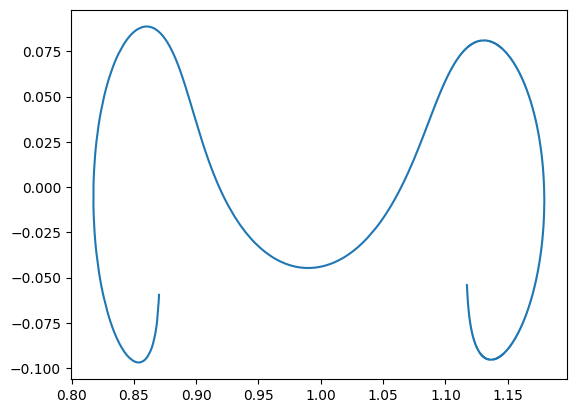

In [113]:
plt.plot(trajectory[:,0], trajectory[:,1])

In [114]:
# three body problem env
class ThreeBodyEnv(gym.Env):
    def __init__(self, trajectory_, error_range=0.1, final_range=0.1):
        self.trajectory = trajectory_
        self.state = np.zeros(4)
        self.dt = 0.01
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-4, high=4, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.position = trajectory_[0]
        self.steps = 0
        self.max_steps = 1000
        self.final_range = final_range
        self.error_range = error_range
        self.reward_range = (-float('inf'), float('inf'))
        self.render_logic = False
        # second player
        self.second_player = False
        self.reset()

    def step(self, action):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]

        # force = action[0] * env.state[2:] + action[1] * env.state[:2]
        a_x = action[0]/100
        a_y = action[1]/100
        # add second player action
        a_x_2 = action[2]/100 if self.second_player else 0
        a_y_2 = action[3]/100 if self.second_player else 0


        r1 = np.sqrt((x+self.mu)**2 + y**2)
        r2 = np.sqrt((x-1+self.mu)**2 + y**2)

        xddot = 2*ydot + x -(1-self.mu)*((x+self.mu)/(r1**3)) - self.mu*(x-1+self.mu)/(r2**3) + a_x + a_x_2
        yddot = -2*xdot + y - (1-self.mu)*(y/(r1**3)) - self.mu*y/(r2**3) + a_y + a_y_2

        x = x + xdot*self.dt
        y = y + ydot*self.dt

        xdot = xdot + xddot*self.dt
        ydot = ydot + yddot*self.dt

        self.position = np.array([x, y, xdot, ydot])

        self.steps += 1

        self.position2state()

        # plot position
        if self.render_logic:
            plt.plot(x, y, 'ro')
            plt.plot(self.trajectory[:,0], self.trajectory[:,1])
            plt.show()

        reward = 100*(1 - np.linalg.norm(self.state, axis=0) + self.steps /1000 - (a_x/10)**2 - (a_y/10)**2 + (a_x_2/10)**2 + (a_y_2/10)**2) - 100
        done = self.steps >= self.max_steps
        states_array.append(self.state)
        if np.linalg.norm(self.position[0:2] - self.trajectory[-1, 0:2]) < self.final_range:
            done = True
            reward = 100
            print(colorize("done 🥺", 'green', bold=True))
        if self.steps > 1000:
            done = True
            reward = -100
            print("end time")
        if self.error_calculation() > self.error_range:
            print(self.state)
            done = True
            reward = -10
            print(colorize("too much error 🥲😱", 'red', bold=True))



        # print(self.state, reward, done, self.position)
        return 1000*self.state, reward, done, False, self.position

    def position2state(self):
        # find the nearest point from position to trajectory
        distance = np.linalg.norm(self.trajectory[:,0:2] - self.position[0:2], axis=1) # just add position and delete velocity
        nearest_idx = np.argmin(distance)
        # estate = position - nearest(index)
        self.state = self.position - self.trajectory[nearest_idx]
        # self.state = self.state * np.array([10, 10, 1, 1])

    def error_calculation(self):
        normalized_error = self.state * np.array([1, 1, 0.0, 0.0]) # reduce the effect of velocity error
        return np.linalg.norm(normalized_error)

    def reset(self,
              *,
              seed: 5 = None,
              return_info: bool = False,
              options: 6 = None):
        self.position = self.trajectory[0]
        self.steps = 0
        self.position2state()
        return 1000*self.state, {}

In [115]:
# Define variables directly
env = ThreeBodyEnv(trajectory)
hid = 32
l = 2
gamma = 0.99
seed = 0
epochs = 50
exp_name = 'ddpg'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ac_kwargs = dict(hidden_sizes=[hid]*l)
states_array = []
logger_kwargs = setup_logger_kwargs(exp_name, seed)
reward_array=[]
ddpg = DDPG(lambda : ThreeBodyEnv(trajectory, error_range=0.01, final_range=0.001), MLPActorCritic, ac_kwargs, seed_=seed,
            steps_per_epoch=4000, epochs_=epochs, logger_kwargs_=logger_kwargs, device=device)

Logging data to /Users/Ali/Documents/BAI/Master/Master_papers/DGDDPG/Code/data/ddpg/ddpg_s0/progress.txt
Saving config:

{
    "ac_kwargs_":	{
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "act_dim":	2,
    "act_noise":	0.1,
    "actor_critic":	"MLPActorCritic",
    "batch_size":	128,
    "device":	"cpu",
    "env_fn":	"<function <lambda> at 0x16b7cea20>",
    "epochs_":	50,
    "exp_name":	"ddpg",
    "gamma_":	0.99,
    "logger_kwargs_":	{
        "exp_name":	"ddpg",
        "output_dir":	"/Users/Ali/Documents/BAI/Master/Master_papers/DGDDPG/Code/data/ddpg/ddpg_s0"
    },
    "max_ep_len":	1000,
    "num_test_episodes":	10,
    "obs_dim":	[
        4
    ],
    "p":	"Parameter containing:\ntensor([-0.1749])",
    "pi_lr":	0.001,
    "polyak":	0.995,
    "q_lr":	0.001,
    "replay_size":	1000000,
    "save_freq":	1,
    "seed_":	0,
    "self":	{
        "<__main__.DDPG object at 0x16b43ae10>":	{
            "ac":	{
                "MLPActorCritic(\n  (p

In [116]:
# print(ddpg.ac.pi)
# dot = torchviz.make_dot(ddpg.ac.pi(torch.randn(1, ddpg.obs_dim[0], device=device)), params=dict(ddpg.ac.pi.named_parameters()), show_attrs=True)
# dot.graph_attr.update(size="10,10")
# dot

[0.00894776 0.00500182 0.05854374 0.02592607]
too much error 🥲😱
[ 0.01011796 -0.0005615   0.03063842 -0.00928998]
too much error 🥲😱
[ 0.00980971 -0.00312946  0.0314888  -0.0127263 ]
too much error 🥲😱
[ 0.00902383 -0.00453921  0.02872669 -0.01024846]
too much error 🥲😱
[ 0.00914316 -0.00460206  0.02811673 -0.01528079]
too much error 🥲😱
[-0.00908182 -0.00472487 -0.05587121  0.00134387]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00993325  0.00126105  0.03434979 -0.0036508 ]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[ 0.00997924 -0.00186441  0.03114026 -0.01128952]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.01021418 -0.00072227  0.03225674 -0.00806053]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[ 0.010172   -0.00069763  0.03324325 -0.00619965]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00975905 -0.00233438  0.03031962 -0.01172675]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[ 0.00989998 -0.00237098  0.03049233 -0.011291

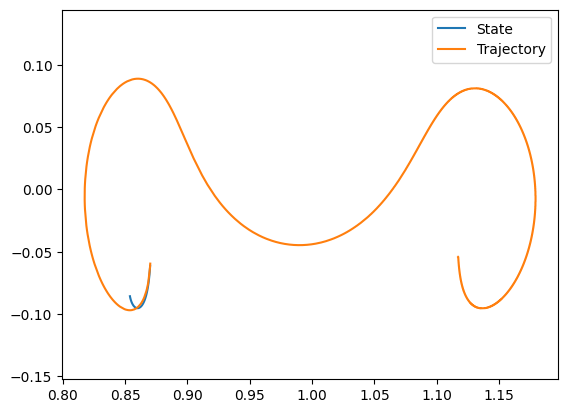

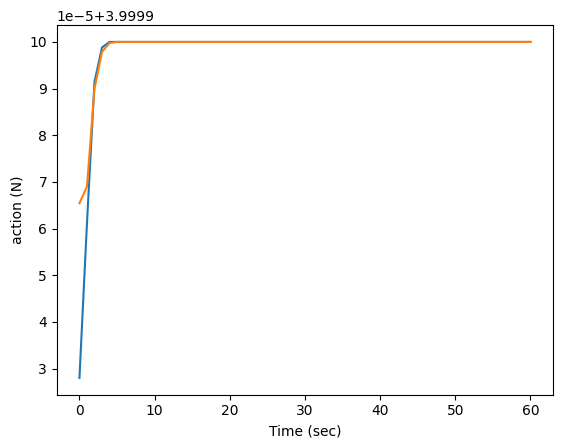

[-0.00951092  0.00601797  0.03173     0.1673043 ]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[ 0.01001959 -0.00235261  0.03248276 -0.00752438]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 1.01619791e-02  5.94499140e-06  3.38070758e-02 -6.54432936e-03]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[ 0.00979303 -0.00305061  0.03071341 -0.00502577]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 1.00577150e-02  2.93902847e-05  3.33789450e-02 -4.50920194e-03]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[ 0.01025744  0.00087086  0.03444387 -0.00506774]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 1.01251699e-02 -2.45056748e-05  3.24930703e-02 -6.21395513e-03]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00975325 -0.00233591  0.03043707 -0.00870224]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[ 0.00564791 -0.00827655  0.03146287  0.01537206]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.01006927  0.00

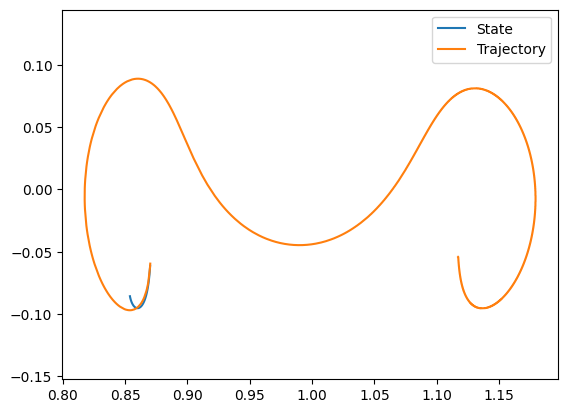

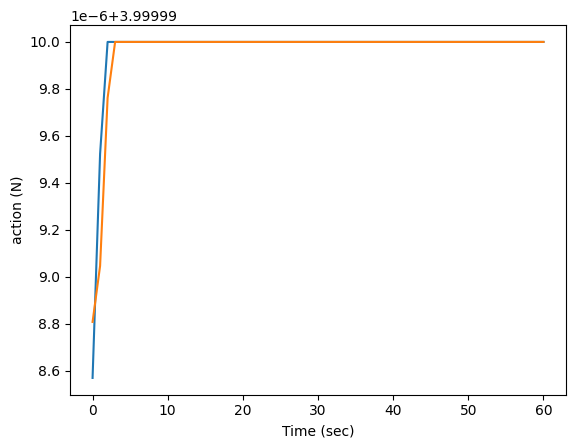

[-0.00951091  0.00601797  0.03142899  0.16744938]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[ 0.01006564 -0.00136894  0.03108852 -0.00879539]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[ 0.00983972 -0.00251444  0.0306327  -0.01141231]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 1.01186960e-02 -1.85955066e-05  3.22177326e-02 -5.61366146e-03]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.01009365 -0.00063748  0.03248538 -0.00701861]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[ 0.00810994 -0.00612907  0.02615144 -0.00799518]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[ 0.00912314  0.00431292  0.04121413 -0.00197456]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.0100563   0.00050607  0.03306113 -0.00468284]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[ 0.00975589 -0.00230518  0.02981167 -0.01077919]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
updating  🥰☺️
[ 0.00997202 -0.000868

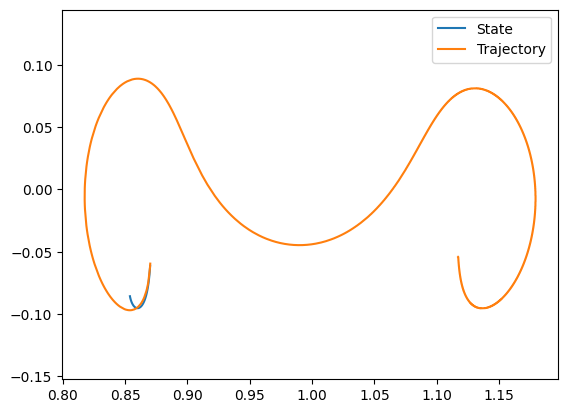

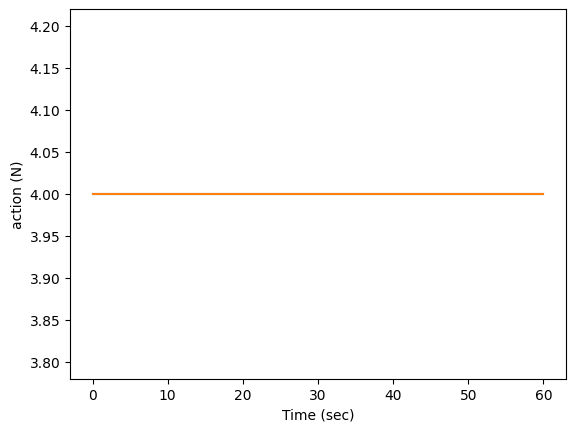

[-0.00951091  0.00601797  0.0321124   0.16754575]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00851986  0.00639893  0.03252424  0.15531784]
too much error 🥲😱
updating  🥰☺️
[-0.00729879  0.00685747  0.03342808  0.14198279]
too much error 🥲😱
updating  🥰☺️
[-0.00853849  0.0064121   0.0324749   0.1553642 ]
too much error 🥲😱
updating  🥰☺️
[-0.00855853  0.00639642  0.03235975  0.15534706]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00732254  0.00681732  0.03326933  0.14188862]
too much error 🥲😱
updating  🥰☺️
[-0.00856569  0.00638266  0.03230314  0.15536613]
too much error 🥲😱
updating  🥰☺️
[-0.00856531  0.00636481  0.03227003  0.1553343 ]
too much error 🥲😱
updating  🥰☺️
[-0.00730235  0.00685748  0.03342883  0.14200467]
too much error 🥲😱
updating  🥰☺️
[-0.00854963  0.00638391  0.03237081  0.15533765]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[-0.00856193  0.00639814  0.0323657   0.15534676]
too much error 🥲😱
updating  🥰☺️
[-0.00858795  0.006372    0.03224664  0.15532652]
too mu

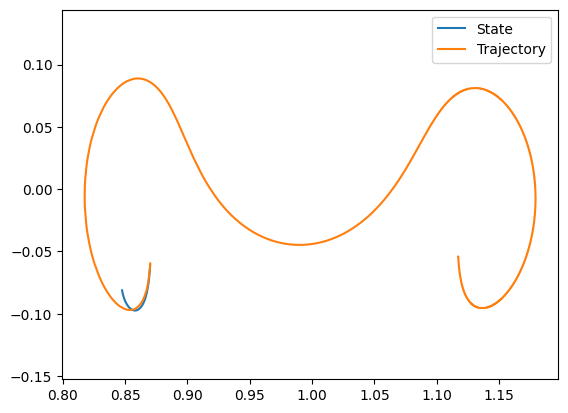

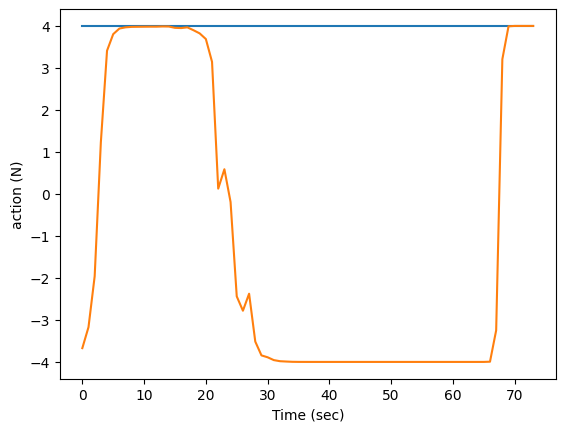

[0.00884671 0.00659976 0.05515    0.01855621]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[0.00801636 0.00670505 0.05330174 0.01989631]
too much error 🥲😱
updating  🥰☺️
[0.00810723 0.00647103 0.05287568 0.0193397 ]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[0.00823783 0.00602893 0.05208719 0.01844227]
too much error 🥲😱
updating  🥰☺️
[0.00778884 0.00633301 0.05181725 0.01884786]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[0.00970396 0.00247892 0.05035267 0.0063701 ]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[0.01019852 0.00227528 0.05140799 0.0063111 ]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[0.00973098 0.0025729  0.05058588 0.00751087]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[0.00805429 0.00606583 0.05185369 0.01880477]
too much error 🥲😱
updating  🥰☺️
[0.00796337 0.00667092 0.05306538 0.02003351]
too much error 🥲😱
updating  🥰☺️
updating  🥰☺️
[0.00805903 0.00634588 0.05275236 0.02011984]
too much error 🥲😱
updating  🥰☺️
[0.00754558 0.00667237 0.05232938 0.02152857

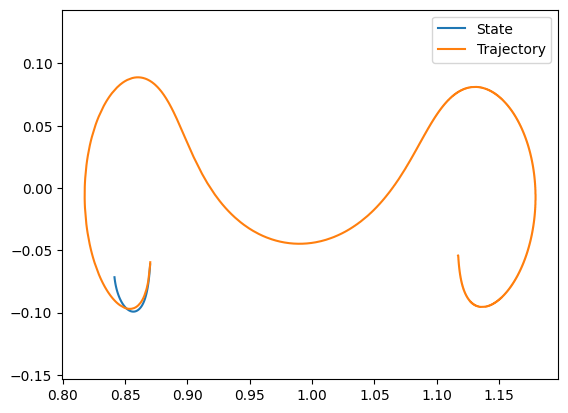

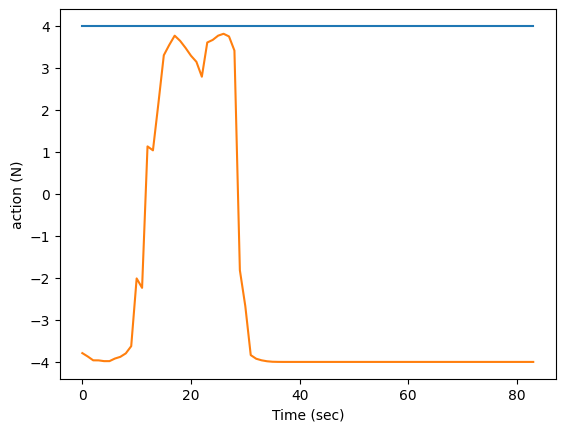

In [117]:
ddpg.train(epochs_=5)

[0.00924448 0.00489225 0.0526733  0.00324361]
too much error 🥲😱
(9999, 6)


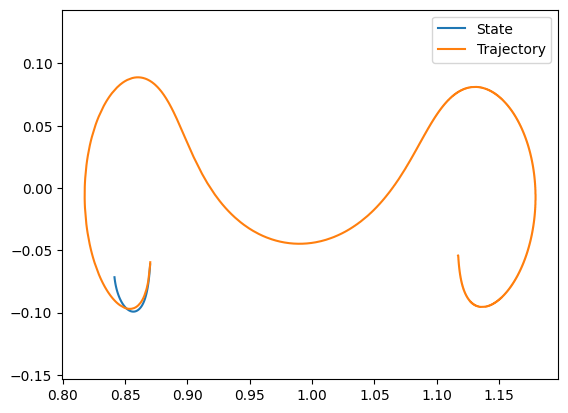

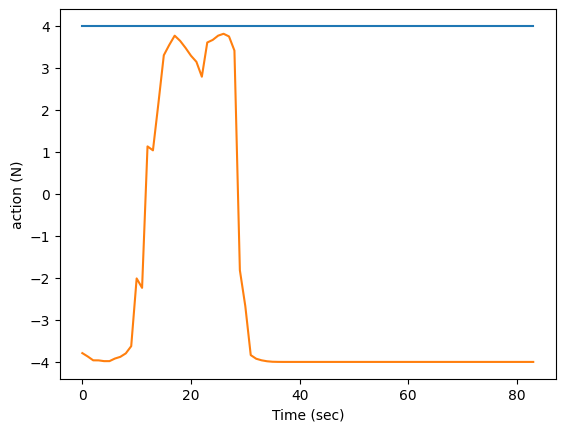

In [118]:
ddpg.test()

In [119]:
print(reward_array)

[0.061208895285119524, 0.15611114102169665, 0.28758040286318476, 0.3564267123392, 0.4431358363796676, 0.5250737882611674, 0.6178237708151784, 0.6837201389893863, 0.8061324736306545, 0.875686284347978, 0.946650201393993, 1.0258585367496522, 1.1167805626498932, 1.2108084551252887, 1.30814445568042, 1.3718769007113423, 1.407733908333114, 1.5006175417892962, 1.619613137716371, 1.6663240391394254, 1.756006861427096, 1.85276894047972, 1.9615339929797813, 2.0453616475519567, 2.1155190235039925, 2.236385418445863, 2.361494658588853, 2.3974083576575396, 2.5607221236171966, 2.6706702084263014, 2.8469126312668607, 2.984569566666991, 3.10365027845107, 3.2665625837747143, 3.376204956543887, 3.4852276366949155, 3.5217143484168787, 3.5728555189439106, 3.6919367602567377, 3.7527297156571677, 3.764214694911942, 3.795957074687095, 3.8699215445943764, 3.922032681841216, 3.9821960263144405, 4.034080588049875, 4.092397597882069, 4.188669716995946, 4.310030585928956, 4.355341919733078, 4.4893561612458655, 4

In [120]:
rewards = np.array(reward_array)

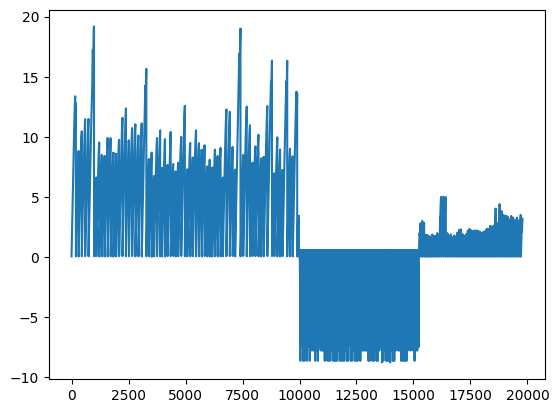

In [121]:
rewards_ = rewards[rewards != -10]
plt.plot(rewards_)

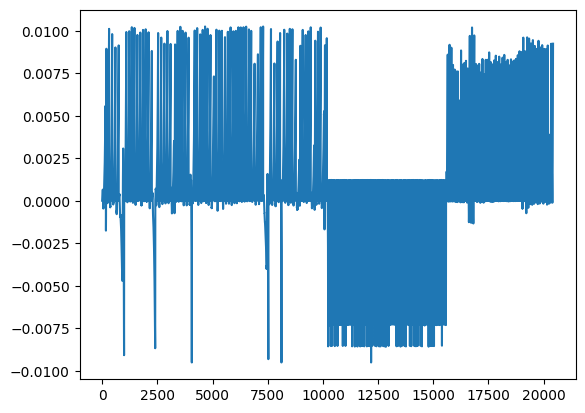

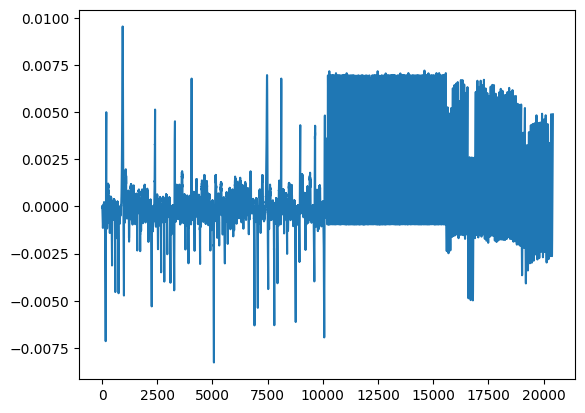

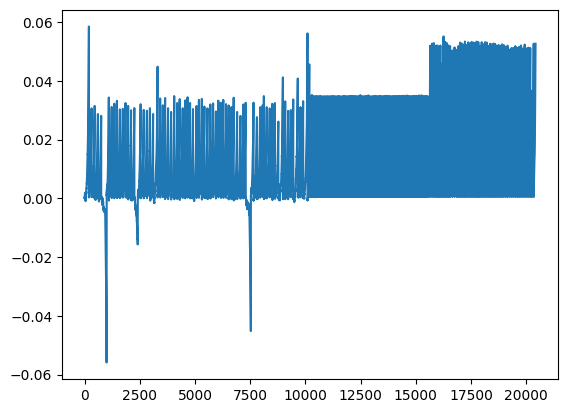

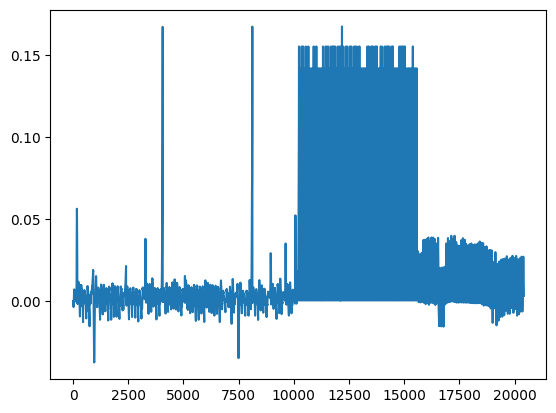

In [122]:
# ddpg.train(epochs_=500)
states = np.array(states_array)
# separate figure for each state
for i in range(states.shape[1]):
    plt.plot(states[:,i])
    plt.show()


[0.00924448 0.00489225 0.0526733  0.00324361]
too much error 🥲😱
(9999, 6)


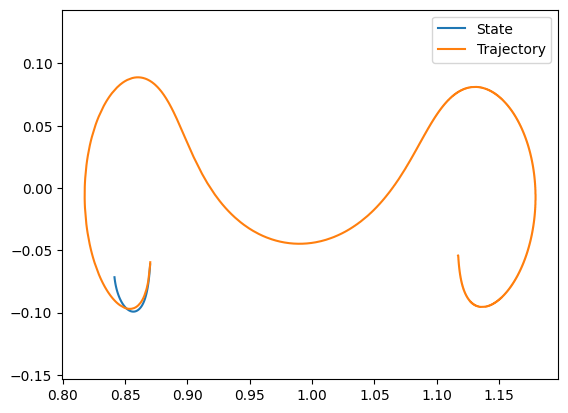

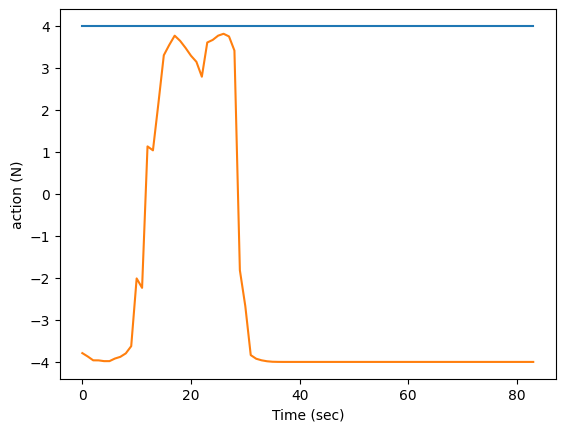

In [123]:
ddpg.test()